## Load packages

In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

tqdm.pandas()

## Load datasets

In [2]:
# Load the main dataset
df = pd.read_pickle("data/pkl/extracted-quotes-2020.pkl")

In [3]:
# Load the dataset with additional info abbout politicians 
df_politicians = pd.io.json.read_json("data/resources/new_congress_biolist.json")

## Work on df_politicians table

In [4]:
# Extract from congresses column relevant infor (position, state, parties)
def extract_congress_information(row):
    information = pd.json_normalize(row["congresses"]).sort_values("congressNumber").tail(1).loc[:, ["position","stateName","parties"]]

    row["position"] = information.loc[:, "position"].values[0]
    row["stateName"] = information.loc[:, "stateName"].values[0]
    row["parties"] = information.loc[:, "parties"].values[0]
    return row

df_politicians = df_politicians.progress_apply(extract_congress_information, axis=1)

100%|██████████| 1162/1162 [00:05<00:00, 207.68it/s]


In [5]:
# The value in column parties is a list, we want to select the last past party from the list
def getLastValue(aList):
    return aList[-1]

df_politicians["parties"] = df_politicians["parties"].apply(getLastValue)

In [6]:
# Create new column speaker (full name of the politician)
df_politicians['speaker'] = df_politicians['givenName'] + " " + df_politicians['familyName']

# Have the speaker's full names in the same size 
df_politicians["speaker"] = df_politicians["speaker"].str.lower()

# In lower case also in the quotes dataset
df["speaker"] = df["speaker"].str.lower()

In [8]:
# Check for full name duplicates
# I propose to delete those as they may be in different parties and we will not which one is talking
df_politicians['speaker'].value_counts()

donald trump              3
president donald trump    2
donald payne              2
duncan hunter             2
patrick murphy            2
                         ..
ruben gallego             1
pete gallego              1
elton gallegly            1
michael gallagher         1
ro khanna                 1
Name: speaker, Length: 1154, dtype: int64

In [ ]:
df_politicians

In [9]:
# We drop duplicates by speaker's full name
df_politicians = df_politicians.drop_duplicates(subset=['speaker'])

## Merge the quotes with info about speakers

In [10]:
# Merge quotes to speaker's info
data = pd.merge(df, df_politicians, on='speaker', how='outer') # we merged the dataset

In [15]:
# Subsets by parties 
subset_democrats = data[data['parties'] == "Democrat"]
subset_republicans = data[data['parties'] == "Republican"]

In [21]:
subset_republicans[subset_republicans["speaker"] == "president donald trump"].head(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,subset,...,deathYear,congresses,middleName,unaccentedMiddleName,nickName,honorificPrefix,honorificSuffix,position,stateName,parties
31674,2020-01-15-070902,"so after years of devastating defense cuts, we...",president donald trump,[Q22686],2020-01-15 00:34:00,1.0,"[[President Donald Trump, 0.6652], [None, 0.33...",[http://www.wpr.org/keep-america-great-preside...,E,True,...,NaN,"[{'position': 'President', 'congressNumber': N...",John,John,None,None,None,President,None,Republican
31675,2020-03-02-060002,there are fringe globalists that would rather ...,president donald trump,[Q22686],2020-03-02 23:41:58,1.0,"[[President Donald Trump, 0.8366], [None, 0.16...",[http://breitbart.com/politics/2020/03/02/live...,E,True,...,NaN,"[{'position': 'President', 'congressNumber': N...",John,John,None,None,None,President,None,Republican
31676,2020-01-29-117540,we will make sure they face another crushing d...,president donald trump,[Q22686],2020-01-29 01:57:00,3.0,"[[President Donald Trump, 0.4479], [None, 0.32...",[https://www.msn.com/en-us/news/elections-2020...,E,True,...,NaN,"[{'position': 'President', 'congressNumber': N...",John,John,None,None,None,President,None,Republican
31677,2020-03-30-070472,why aren't you using these ventilators?,president donald trump,[Q22686],2020-03-30 18:41:40,1.0,"[[President Donald Trump, 0.5024], [None, 0.49...",[https://www.factcheck.org/2020/03/trump-vs-cu...,E,True,...,NaN,"[{'position': 'President', 'congressNumber': N...",John,John,None,None,None,President,None,Republican
31678,2020-01-21-000832,a blue collar boom.,president donald trump,[Q22686],2020-01-21 00:00:00,5.0,"[[President Donald Trump, 0.6469], [None, 0.34...",[http://feeds.benzinga.com/~r/benzinga/~3/w9r5...,E,True,...,NaN,"[{'position': 'President', 'congressNumber': N...",John,John,None,None,None,President,None,Republican


## Naive model: select quotes that talk about the opponent party

In [19]:
# Get the list of Republicans and Democrats
names_democrats = df_politicians[df_politicians['parties'] == 'Democrat']["speaker"].tolist()
names_republicans = df_politicians[df_politicians['parties'] == 'Republican']["speaker"].tolist()

In [20]:
# Have all quotes in lowercase
data["quotation"] = data["quotation"].str.lower()
subset_democrats["quotation"] = subset_democrats["quotation"].str.lower()
subset_republicans["quotation"] = subset_republicans["quotation"].str.lower()

/tmp/ipykernel_93937/3982307100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_democrats["quotation"] = subset_democrats["quotation"].str.lower()
/tmp/ipykernel_93937/3982307100.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_republicans["quotation"] = subset_republicans["quotation"].str.lower()


In [706]:
# Drop rows with those who don't have any quotes
data = data.dropna(subset=['quotation'])
subset_democrats = subset_democrats.dropna(subset=['quotation'])
subset_republicans = subset_republicans.dropna(subset=['quotation'])

In [707]:
# Create full lists 
list_rep = names_republicans + ['republican', 'republicans', "donald trump"]
pattern_list_rep = '|'.join(list_rep)

list_dem = names_democrats + ['democrat', 'democrats']
pattern_list_dem = '|'.join(list_dem)

In [709]:
# Subset of quotes said by democrats about republicans
demo_quotes_abt_rep = subset_democrats[subset_democrats['quotation'].str.contains(pattern_list_rep)]

In [710]:
# Subset of quotes said by democrats about democrats
rep_quotes_abt_demo = subset_republicans[subset_republicans['quotation'].str.contains(pattern_list_dem)]

## Sentiment analysis of the quotes

### Use of nltk package

In [716]:
import nltk
# nltk.download()
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/darynabilodid/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [762]:
# Function that get the sentiment of each quote
def get_sentiment(row):   
    row['NLTK score'] = sia.polarity_scores(row['quotation'])
    return row

In [763]:
# Apply function on the subsets - for republicans and democrats
demo_quotes_abt_rep = demo_quotes_abt_rep.apply(get_sentiment, axis=1)
rep_quotes_abt_demo = rep_quotes_abt_demo.apply(get_sentiment, axis=1)

In [770]:
# Split in columns to get values 
# Democrats about republicans 
demo_quotes_abt_rep = pd.concat([demo_quotes_abt_rep, demo_quotes_abt_rep['NLTK score'].apply(pd.Series)], axis=1)

# Republicans about democrats
rep_quotes_abt_demo = pd.concat([rep_quotes_abt_demo, rep_quotes_abt_demo['NLTK score'].apply(pd.Series)], axis=1)


## EDA:  We have 2 datasets that we want to analyze

The problem is that we have too quotes classified as neutral. 
We should read about SentimentIntensityAnalyzer as we may need to preprocess before, or use a different sentiment predictor.
Another thing: may be we should appply the analyzer before even lower casing the sentences (because maybe some excitement/anger can be in upper case)
Something to think about.
https://www.analyticsvidhya.com/blog/2021/01/sentiment-analysis-vader-or-textblob/

#### Republicans about democrats 

In [785]:
rep_quotes_abt_demo.head(1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,subset,...,honorificPrefix,honorificSuffix,position,stateName,parties,NLTK score,neg,neu,pos,compound
4678,2018-03-07-104175,not all visitors to our parks have the ability...,ryan zinke,[Q7384672],2018-03-07 22:44:57,1.0,"[[Ryan Zinke, 0.7164], [None, 0.2109], [Lamar ...",[http://pressandguide.com/blogs/gr8_lakes_camp...,E,True,...,NaN,NaN,Representative,MT,Republican,"{'neg': 0.0, 'neu': 0.919, 'pos': 0.081, 'comp...",0.0,0.919,0.081,0.7906


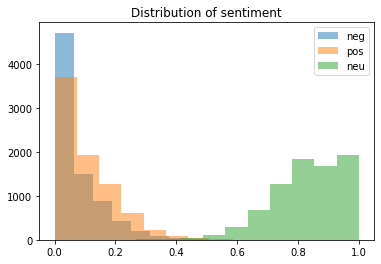

In [802]:
plt.hist(rep_quotes_abt_demo['neg'], alpha=0.5);
plt.hist(rep_quotes_abt_demo['pos'], alpha=0.5);
plt.hist(rep_quotes_abt_demo['neu'], alpha=0.5);
labels = ['neg','pos', 'neu'];
plt.title('Distribution of sentiment');
plt.legend(labels);